Il file 'Data.csv' contiene i dati relativi al consumo di energia elettrica della macchina del caffè di Alexide.\
La colonna **Date** rappresenta data e ora della registrazione del sensore. Si noti che le date sono espresse in UTC.
Per convertirle nella timezone locale utilizzare\
`df['Date'] = pd.to_datetime(df['Date'], utc = True).dt.tz_convert('Europe/Berlin')`\
La colonna **Energy** rappresenta il consumo di energia totale, espresso in W*min (Watt minuto), a partire dall'accensione del sensore.
Si noti che il sensore è stato riavviato diverse volte nel periodo di osservazione e, a seguito di ciascun riavvio, il conteggio è ripartito da 0.\
La colonna **Topic** rappresenta il topic del messaggio mqtt ricevuto dal sensore.

Rappresentare i consumi totali in kWh (kiloWatt ora) con una heatmap che abbia sull'asse x le ore del giorno e sull'asse y il giorno della settimana.

# Coffe Machine Heatmap

#### Installo le librerie necessarie

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

#### 1. Dopo aver importato pandas leggo <tt>data.csv</tt> in un dataframe  <tt>df</tt>.

In [16]:
df = pd.read_csv('data.csv',  sep=';')

In [17]:
df['Date'] = pd.to_datetime(df['Date'], utc = True).dt.tz_convert('Europe/Berlin')

#### 2. Exploring the dataframe

In [18]:
# Verifico che la data sia stata convertita nel tipo corretto (datetime64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8080 entries, 0 to 8079
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype                        
---  ------  --------------  -----                        
 0   Energy  8080 non-null   int64                        
 1   Date    8080 non-null   datetime64[ns, Europe/Berlin]
 2   Topic   8080 non-null   object                       
dtypes: datetime64[ns, Europe/Berlin](1), int64(1), object(1)
memory usage: 189.5+ KB


In [19]:
df.set_index('Date', inplace=True)
df

,Energy,Topic
Date,,
2022-10-04 09:44:00+02:00,31678,shellies/shellyplug-s-D9B9EB/relay/0/energy
2022-10-04 09:45:02+02:00,31680,shellies/shellyplug-s-D9B9EB/relay/0/energy
2022-10-04 09:46:04+02:00,31688,shellies/shellyplug-s-D9B9EB/relay/0/energy
2022-10-04 09:47:21+02:00,31692,shellies/shellyplug-s-D9B9EB/relay/0/energy
2022-10-04 09:48:15+02:00,31694,shellies/shellyplug-s-D9B9EB/relay/0/energy
...,...,...
2022-09-25 09:38:57+02:00,243827,shellies/shellyplug-s-D9B9EB/relay/0/energy
2022-09-25 09:38:59+02:00,243838,shellies/shellyplug-s-D9B9EB/relay/0/energy
2022-09-25 09:40:09+02:00,243839,shellies/shellyplug-s-D9B9EB/relay/0/energy


Text(0, 0.5, 'Energy')

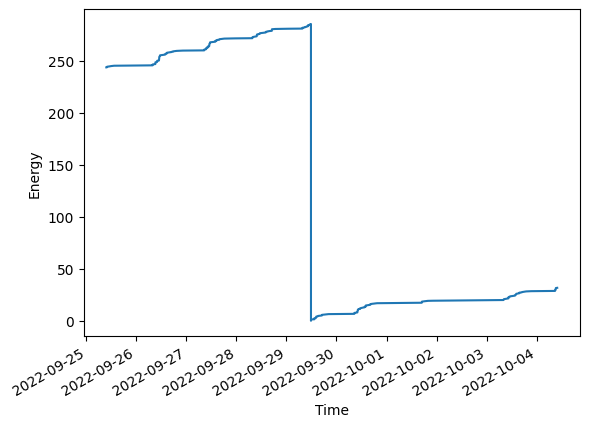

In [20]:
df['Energy'] = df['Energy'] / 1000 
plot = df['Energy'].plot()
plot.set_xlabel("Time")
plot.set_ylabel("Energy")

<AxesSubplot: xlabel='Date'>

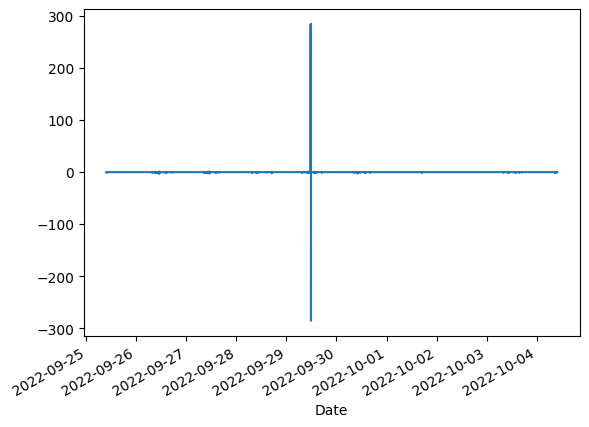

In [21]:
df['DeltaEnergy'] = df['Energy'].diff()

<AxesSubplot: xlabel='Date'>

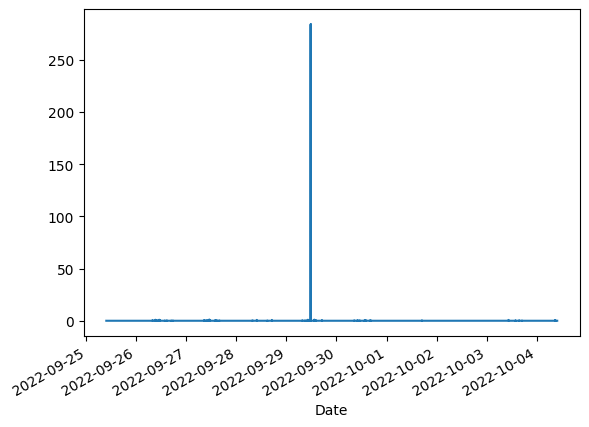

In [22]:
df = df[df['DeltaEnergy'] > 0]
df['DeltaEnergy'].plot()

C:\Users\Gerry\AppData\Local\Temp\ipykernel_1152\2738414297.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('H').sum()


<AxesSubplot: xlabel='Date'>

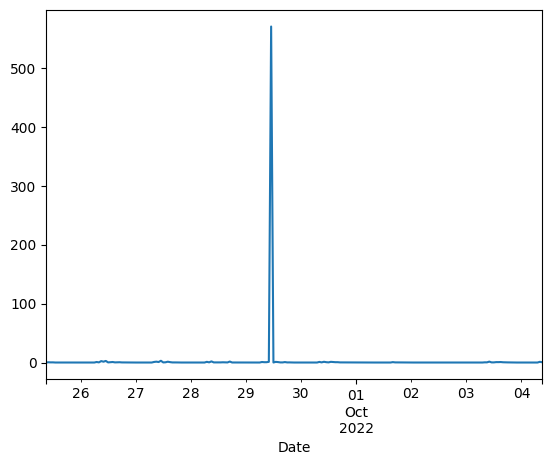

In [23]:
df = df.resample('H').sum()
df['DeltaEnergy'].plot()

In [24]:
df = df.reset_index()
df["Hour"] = df["Date"].dt.hour
df["Weekday"] = df["Date"].dt.weekday
weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Weekday"] = df["Weekday"].apply(lambda x: weekday_names[x])
df = df.drop(columns=['Date'])
df = df.drop(columns=['Energy'])


In [25]:
df = df.groupby(['Weekday', 'Hour']).sum()
df

DeltaEnergy
Weekday   Hour             
Friday    0           0.020
          1           0.019
          2           0.020
          3           0.019
          4           0.016
...                     ...
Wednesday 19          0.065
          20          0.030
          21          0.017
          22          0.014
          23          0.016

[168 rows x 1 columns]

In [26]:
df = df.unstack()

In [27]:
df.columns = df.columns.droplevel(0)
df = df.drop_duplicates()
df

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Weekday,,,,,,,,,,,,,,,,,,,,,
Friday,0.020,0.019,0.020,0.019,0.016,0.015,0.015,0.015,1.039,0.271,...,0.883,0.560,0.575,0.220,0.194,0.077,0.016,0.016,0.015,0.012
Monday,0.033,0.029,0.027,0.027,0.030,0.029,0.030,0.908,0.593,2.738,...,1.555,1.073,0.843,0.762,0.422,0.265,0.119,0.032,0.027,0.030
Saturday,0.016,0.018,0.015,0.015,0.015,0.014,0.014,0.017,0.014,0.018,...,0.016,0.016,0.679,0.226,0.181,0.220,0.014,0.017,0.015,0.015
Sunday,0.014,0.013,0.014,0.017,0.017,0.015,0.018,0.017,0.019,0.088,...,0.033,0.035,0.031,0.032,0.031,0.034,0.029,0.029,0.028,0.028
Thursday,0.015,0.016,0.016,0.016,0.015,0.016,0.014,0.894,0.555,0.558,...,0.756,0.186,0.181,0.765,0.185,0.219,0.040,0.019,0.019,0.020
Tuesday,0.031,0.031,0.031,0.028,0.029,0.032,0.031,0.030,2.141,1.969,...,1.386,0.670,0.183,0.197,0.151,0.019,0.019,0.018,0.018,0.019
Wednesday,0.021,0.018,0.019,0.015,0.016,0.016,0.016,1.163,0.317,1.931,...,0.412,0.217,0.160,1.669,0.078,0.065,0.030,0.017,0.014,0.016


<AxesSubplot: xlabel='Hour', ylabel='Weekday'>

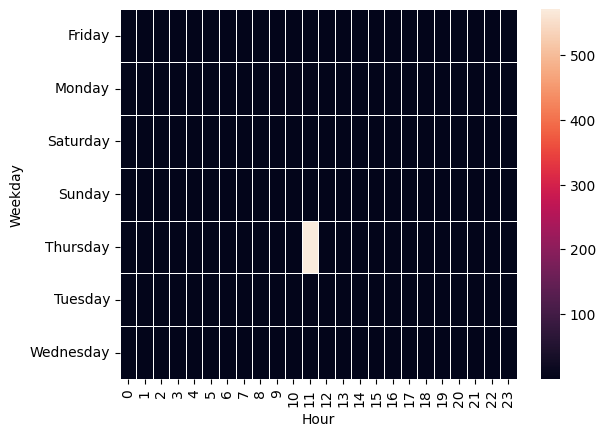

In [28]:
import seaborn as sns
sns.heatmap(df, linewidths=.5)